# Final project

This notebook together with the 'final_project' directory in this repository contains all the data and code used to create a final project on the course `Practical analysis of noisy and uneven time series` on `Advanced Data Analytics` master program on the University of Belgrade.
In the notebook, we will work with light curves with the main focus of applying prestatistical analyses using packages such as `numpy` and `pandas` and modelling neural processes with the implementation of `QNPy` a proprietary python package for modelling quasar time series using neural processes.

In [1]:
__author__ = 'Damir Bogdan <damirbogdan39@gmail.com>'
__version__ = '20230411'
__keywords__ = ['lightcurve', 'quasars', 'clustering', 'nerual processes']

In [10]:
# Importing dependencies

import os
from glob import glob

import pandas as pd
import numpy as np
from scipy.stats import kendalltau

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Utilities
from utils import count_outliers

# Constants
from constants import *

In this notebook I will be using some well-known libraries used in the data science community such as `pandas` and `numpy` for maniplation of numerical data, as well as `matplotlib` and `plotly` for the visualizations.

Aside from these libraries I will be using some of the functions I have made for this project which will be imported from `utils`.

In [3]:
# QNPy dependencies

import QNPy #Importing the package

# Preprocessing
from QNPy import Preprocess as pr #Importing Preprocess module from the package
from QNPy.Preprocess import transform #importing the funcion transform for transformation the data
from QNPy.Preprocess import * #importing all external packages from Preprocess

# Splitting and training
from QNPy import SPLITTING_AND_TRAINING as st
from QNPy.SPLITTING_AND_TRAINING import *

# Prediction 
from QNPy import PREDICTION as pred #Importing PREDICTION module from the package
from QNPy.PREDICTION import * #Importing all packages from PREDICTION module
from QNPy.PREDICTION import plot_function #The functions plot_function must be imported separately

I would like to make my first impression here.
While working through the tutorial I went through severals different notebooks which showed how to implement QNPy.

In the preprocessing tutorial this piece of code `from QNPy import Preprocess as pr` interfered with the prediction tutorials code `from QNPy import PREDICTION as pr` which resulted in some errors. The solution to this is to change one of the alias of these two packages. 

So I have made the change and aliased `PREDICTION` as `pred`.

In [2]:
pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.21.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (15.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.2 requires torch==2.0.1, but you have torch 1.13.0 which is incompatible.
tensorflow 2.15.0.post1 requires numpy<2.0.0,>=1.23.5, but you have numpy 1.21.5 which is incompatible.
numba 0.58.1 requires numpy<1.27,>=1.22, but you have numpy 1.21.5 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [9]:
ls -la

total 4272
drwxrwxr-x 9 damir damir    4096 дец 14 19:57 ./
drwxrwxr-x 6 damir damir    4096 нов 18 11:44 ../
-rw-rw-r-- 1 damir damir     674 дец 15 19:04 constants.py
-rwxrwxrwx 1 damir damir     404 нов 30 09:42 create_directories.sh*
drwxrwxr-x 5 damir damir    4096 нов 21 11:40 dataset/
-rw-rw-r-- 1 damir damir   48895 дец 14 19:57 epoch_counter_train_loss.csv
-rw-rw-r-- 1 damir damir   48895 дец 14 19:57 epoch_counter_train_mae.csv
-rw-rw-r-- 1 damir damir   48895 дец 14 19:57 epoch_counter_train_mse.csv
-rw-rw-r-- 1 damir damir   48895 дец 14 19:57 epoch_counter_val_loss.csv
-rw-rw-r-- 1 damir damir   48895 дец 14 19:57 epoch_counter_val_mae.csv
-rw-rw-r-- 1 damir damir   48895 дец 14 19:57 epoch_counter_val_mse.csv
-rw-rw-r-- 1 damir damir 2869671 дец 15 19:12 final_project.ipynb
-rw-rw-r-- 1 damir damir  179351 дец 14 19:57 history_loss_train.csv
-rw-rw-r-- 1 damir damir  187730 дец 14 19:57 history_loss_val.csv
-rw-rw-r-- 1 damir damir  193579 дец 14 19:57 history_mae_train.c

In [7]:
!bash ./create_directories.sh

In [4]:
# Defining data path

data_path = 'kriveu/'

In the next cell we will import all individual light curves as a `dataframe`. This will allow us to inspect every individual light curve using common `pandas` functions but also visualize them.

In [5]:
# Importing the light curves as dataframes

# Get a list of all files in the folder
all_files = os.listdir(data_path)

all_dataframes = []

# Read each file into a DataFrame and store it in the list
for file_name in all_files:
    try:
        # Construct the full file path
        file_path = os.path.join(data_path, file_name)
        
        # Read the DataFrame and create a variable with the file name
        df = pd.read_csv(file_path)
        globals()['lc_' + os.path.splitext(file_name)[0]] = df
        
        # Add the DataFrame to the list
        all_dataframes.append(df)
    except Exception as e:
        print(f"Error reading {file_name}: {e}")

We also create a combined dataframe called `combined_df` so we can inspect them all as one time series.

In [6]:
# Create a combined dataframe

# Create an empty DataFrame to store the combined data
combined_df = pd.DataFrame()

# Iterate through each file and read it into a DataFrame
for file in all_files:
    # Construct the full file path
    file_path = os.path.join(data_path, file)
    
    # Read the file into a DataFrame
    df = pd.read_csv(file_path)  # Adjust the read function based on your file format
    
    # Add a new column with the file name
    df['light_curve'] = file
    
    # Concatenate the current DataFrame with the combined DataFrame
    combined_df = pd.concat([combined_df, df], ignore_index=True)

## EDA

### Individual light curves

In [7]:
# Loop to print the shape and name of each DataFrame
for file_name, df in zip(all_files, all_dataframes):
    df_name = 'lc_' + os.path.splitext(file_name)[0]
    print(f"{df_name}: {df.shape}")

lc_1397099: (136, 3)
lc_1397703: (117, 3)
lc_1461135: (113, 3)
lc_1385693: (111, 3)
lc_1384888: (142, 3)
lc_1405638: (120, 3)
lc_1384482: (107, 3)
lc_1396377: (125, 3)
lc_1396861: (115, 3)
lc_1385148: (142, 3)
lc_1385498: (151, 3)
lc_1399759: (122, 3)
lc_1384186: (119, 3)
lc_1400894: (144, 3)
lc_1392335: (131, 3)
lc_1409195: (109, 3)


We can see that our dataframes are of different shapes.
Their first dimension differs which means they are not equal in the number of rows which represent the number of timestamps. The smallest light curve consists out of 107 records, and the largest one consist out of 151 records.


In [8]:
# Visualizing lightcurves

for i, df in enumerate(all_dataframes):
    fig = go.Figure()

    trace = go.Scatter(x=df['mjd'], y=df['mag'], mode='markers', name='mag', marker=dict(size=4))

    error_bars = go.Scatter(
        x=df['mjd'],
        y=df['mag'],
        error_y=dict(
            type='data',
            array=df['magerr'],
            visible=True
        ),
        mode='markers',
        marker=dict(size=4),
        name='mag with error bars'
    )

    fig.add_trace(trace)
    fig.add_trace(error_bars)

    fig.update_xaxes(title_text='MJD (Modified Julian Date)')
    fig.update_yaxes(title_text='Magnitude')

    fig.update_layout(title_text=f"Time Series with Error Bars - Plot {i + 1}", showlegend=True)
    fig.show()

In [9]:
# Visualizing box and whisker plots and histograms for all individual light curves

for i, df in enumerate(all_dataframes):
    fig = px.histogram(df, x='mag', marginal='box', nbins=30, title=f"KDE Plot for 'mag' - Plot {i + 1}")

    fig.update_xaxes(title_text='Magnitude')
    fig.update_yaxes(title_text='Density')

    fig.show()

In [10]:
# Get descriptive statistics of each light curve

combined_df.groupby('light_curve')[['mag','magerr']].describe()

mag                                                        \
             count       mean       std        min        25%        50%   
light_curve                                                                
1384186      119.0  21.512480  0.267169  20.926497  21.337043  21.497442   
1384482      107.0  20.517574  0.233113  20.052631  20.337834  20.555767   
1384888      142.0  20.698614  0.282422  20.044104  20.456067  20.728067   
1385148      142.0  20.718475  0.237232  20.166422  20.533610  20.741731   
1385498      151.0  21.304290  0.333977  20.447573  21.031276  21.347416   
1385693      111.0  22.359564  0.474342  21.349648  21.984720  22.381493   
1392335      131.0  22.135060  0.360685  21.368582  21.884486  22.103127   
1396377      125.0  20.863795  0.237016  20.375563  20.677055  20.848343   
1396861      115.0  22.174567  0.339050  21.386015  21.917785  22.207973   
1397099      136.0  21.218165  0.248631  20.577721  21.030034  21.206480   
1397703      117.0  20.545220  0.185631  19.967167  20.439396  20.549681   
1399759      122.0  21.805927  0.336782  20.748985  21.567924  21.796664   
1400894      144.0  21.407895  0.294246  20.610455  21.204825  21.400106   
1405638      120.0  22.258457  0.496609  21.212950  21.884653  22.214561   
1409195      109.0  22.194657  0.606834  20.699173  21.705595  22.174610   
1461135      113.0  20.083718  0.337188  19.377098  19.875856  20.046000   

                                  magerr                                \
                   75%        max  count      mean       std       min   
light_curve                                                              
1384186      21.677734  22.365685  119.0  0.216313  0.105307  0.097014   
1384482      20.669021  21.060968  107.0  0.093443  0.045091  0.049987   
1384888      20.894489  21.604471  142.0  0.116629  0.080655  0.055432   
1385148      20.881122  21.543203  142.0  0.113005  0.056592  0.056342   
1385498      21.540001  22.318247  151.0  0.171525  0.088520  0.069852   
1385693      22.698634  23.408869  111.0  0.366228  0.165402  0.154580   
1392335      22.384416  23.205172  131.0  0.353366  0.178880  0.145286   
1396377      21.015747  21.560387  125.0  0.130656  0.064649  0.060645   
1396861      22.415842  22.860106  115.0  0.370651  0.177187  0.134833   
1397099      21.379022  22.071302  136.0  0.182378  0.099913  0.075628   
1397703      20.650959  21.177103  117.0  0.096162  0.067997  0.048207   
1399759      22.005766  22.771774  122.0  0.245496  0.114854  0.112649   
1400894      21.596160  22.309263  144.0  0.190851  0.097559  0.084997   
1405638      22.537799  23.670122  120.0  0.360356  0.187006  0.125557   
1409195      22.626040  23.890873  109.0  0.340334  0.186465  0.114595   
1461135      20.203922  21.741570  113.0  0.072061  0.039216  0.036599   

                                                     
                  25%       50%       75%       max  
light_curve                                          
1384186      0.146922  0.183407  0.247634  0.723876  
1384482      0.065774  0.081807  0.105345  0.345155  
1384888      0.079260  0.094479  0.123073  0.837994  
1385148      0.080045  0.096158  0.123373  0.460685  
1385498      0.113933  0.145169  0.186886  0.564311  
1385693      0.258830  0.322186  0.431546  0.991525  
1392335      0.227509  0.292343  0.420302  0.972812  
1396377      0.087819  0.106708  0.157727  0.381544  
1396861      0.238324  0.327007  0.443923  0.996839  
1397099      0.115389  0.152943  0.206686  0.663094  
1397703      0.062171  0.075529  0.111715  0.679570  
1399759      0.171642  0.212871  0.289998  0.803579  
1400894      0.129152  0.162043  0.215410  0.572028  
1405638      0.221706  0.310183  0.440372  0.917683  
1409195      0.195294  0.305980  0.432405  0.969698  
1461135      0.047516  0.056554  0.081622  0.250659

In [11]:
# Ge the number of outliers in each light curve

combined_df.groupby('light_curve')[['mag','magerr']].apply(count_outliers)

light_curve
1384186     {'mag': 1, 'magerr': 7}
1384482     {'mag': 0, 'magerr': 6}
1384888    {'mag': 1, 'magerr': 13}
1385148    {'mag': 1, 'magerr': 13}
1385498    {'mag': 1, 'magerr': 14}
1385693     {'mag': 0, 'magerr': 4}
1392335     {'mag': 1, 'magerr': 9}
1396377     {'mag': 1, 'magerr': 8}
1396861     {'mag': 0, 'magerr': 5}
1397099    {'mag': 2, 'magerr': 12}
1397703     {'mag': 4, 'magerr': 4}
1399759     {'mag': 2, 'magerr': 7}
1400894    {'mag': 3, 'magerr': 11}
1405638     {'mag': 2, 'magerr': 7}
1409195     {'mag': 0, 'magerr': 4}
1461135    {'mag': 5, 'magerr': 11}
dtype: object

In [12]:
import plotly.express as px


fig = px.scatter(combined_df, x='mag', y='magerr', title='Scatterplot with Regression Line and Distributions',
                 labels={'mag': 'Magnitude', 'magerr': 'Magnitude Error'},
                 trendline='lowess', trendline_color_override='red',
                 marginal_x='histogram', 
                 marginal_y='histogram',  
                 )

# Adjust the size of the graph
fig.update_layout(height=1000, width=1000)

fig.show()

In [13]:
# Calculating the correlation of the variables

correlation = combined_df['mag'].corr(combined_df['magerr'])

print(f'Correlation between mag and mag_err: {correlation}')

Correlation between mag and mag_err: 0.7477591075963691


In [14]:
# Calculate Kendall's tau
kendall_correlation, p_value = kendalltau(combined_df['mag'], combined_df['magerr'])

print(f'Kendall correlation: {kendall_correlation}')
print(f'p-value: {p_value}')

Kendall correlation: 0.6413961702628765
p-value: 0.0


### All light curves together

In [15]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2004 entries, 0 to 2003
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   mjd          2004 non-null   float64
 1   mag          2004 non-null   float64
 2   magerr       2004 non-null   float64
 3   light_curve  2004 non-null   object 
dtypes: float64(3), object(1)
memory usage: 62.8+ KB


We can see there are no missing values, and all of our original variables are of the correct dtype.

In [16]:
# Visualize all light curves on one graph

fig = px.scatter()

colors = px.colors.qualitative.Set1 + px.colors.qualitative.Pastel1 # Combine two color palletes because Set1 isn't enough

for i, df in enumerate(all_dataframes):
    trace = go.Scatter(
        x=df['mjd'],
        y=df['mag'],
        mode='markers',
        name=f'Plot {i + 1}',
        marker=dict(size=4, color=colors[i % len(colors)])
    )

    error_bars = go.Scatter(
        x=df['mjd'],
        y=df['mag'],
        error_y=dict(
            type='data',
            array=df['magerr'],
            visible=True
        ),
        mode='markers',
        marker=dict(size=4, color=colors[i % len(colors)]),
        showlegend=False
    )

    fig.add_trace(trace)
    fig.add_trace(error_bars)

fig.update_xaxes(title_text='MJD (Modified Julian Date)')
fig.update_yaxes(title_text='Magnitude')

fig.update_layout(title_text="Time Series with Error Bars - All Plots", showlegend=True)
fig.show()

## QNPy implementation

### Preprocessing

In [17]:
# Concatenate the light curves

path = "./light_curves"
files = glob.glob(path + "/*.csv")
df_list = (pd.read_csv(file) for file in files)
data = pd.concat(df_list, ignore_index=True)

In [18]:
# Padding the light curves

padding = pr.backward_pad_curves('./light_curves', './padded_lc', desired_observations=100)

Created new file: ./padded_lc/1385148.csv
Created new file: ./padded_lc/1397703.csv
Created new file: ./padded_lc/1385693.csv
Created new file: ./padded_lc/1384482.csv
Created new file: ./padded_lc/1461135.csv
Created new file: ./padded_lc/1396861.csv
Created new file: ./padded_lc/1400894.csv
Created new file: ./padded_lc/1409195.csv
Created new file: ./padded_lc/1405638.csv
Created new file: ./padded_lc/1397099.csv
Created new file: ./padded_lc/1396377.csv
Created new file: ./padded_lc/1384888.csv
Created new file: ./padded_lc/1385498.csv
Created new file: ./padded_lc/1392335.csv
Created new file: ./padded_lc/1399759.csv
Created new file: ./padded_lc/1384186.csv


In [19]:
padded_files = os.listdir(PADDED_PATH)
padded_files

['1385148.csv',
 '1397703.csv',
 '1385693.csv',
 '1384482.csv',
 '1461135.csv',
 '1396861.csv',
 '1400894.csv',
 '1409195.csv',
 '1405638.csv',
 '1397099.csv',
 '1396377.csv',
 '1384888.csv',
 '1385498.csv',
 '1392335.csv',
 '1399759.csv',
 '1384186.csv']

In [20]:
number_of_points, trcoeff = pr.transform_and_save(padded_files, PADDED_PATH, PREPROC_PATH, transform)

### Splitting the data

In [21]:
preproc_files = os.listdir(PREPROC_PATH) #listing the transformed data

In [ ]:
# Splitting the data

# st.split_data(preproc_files, PREPROC_PATH, TRAIN_DIR, TEST_DIR, VAL_DIR)

### Training the model

In [23]:
# Creating train and validation loaders

train_loader, val_loader = st.get_data_loaders(TRAIN_DIR_PATH, VAL_DIR_PATH, BATCH_SIZE)

In [24]:
# Creating the model and optimizer

model, optimizer, criterion, mse_metric, mae_metric = st.create_model_and_optimizer(DEVICE)

In [ ]:
# Training the model

history_loss_train, history_loss_val, \
history_mse_train, history_mse_val, \
history_mae_train, history_mae_val, \
epoch_counter_train_loss, epoch_counter_train_mse, epoch_counter_train_mae, \
epoch_counter_val_loss, epoch_counter_val_mse, epoch_counter_val_mae = \
st.train_model(model,
               train_loader, val_loader,
               criterion, optimizer,
               1, 10000, 3000,
               mse_metric, mae_metric,
               DEVICE)

100%|██████████| 10000/10000 [26:38<00:00,  6.25it/s]


In [26]:
# Define the file names
file_names = ["history_loss_train.csv", "history_loss_val.csv",
              "history_mse_train.csv", "history_mse_val.csv",
              "history_mae_train.csv", "history_mae_val.csv",
              "epoch_counter_train_loss.csv", "epoch_counter_train_mse.csv", "epoch_counter_train_mae.csv",
              "epoch_counter_val_loss.csv", "epoch_counter_val_mse.csv", "epoch_counter_val_mae.csv"]

# Define the lists
lists = [history_loss_train, history_loss_val,
         history_mse_train, history_mse_val,
         history_mae_train, history_mae_val,
         epoch_counter_train_loss, epoch_counter_train_mse, epoch_counter_train_mae,
         epoch_counter_val_loss, epoch_counter_val_mse, epoch_counter_val_mae]

#Running the function for saving all lists with histories
save_list = st.save_lists_to_csv(file_names, lists)

In [27]:
# Replace with the path to your history_loss_train CSV file
history_loss_train_file = './history_loss_train.csv'  
# Replace with the path to your history_loss_val CSV file
history_loss_val_file = './history_loss_val.csv'  
# Replace with the path to your epoch_counter_train_loss CSV file
epoch_counter_train_loss_file = './epoch_counter_train_loss.csv'  

In [28]:
directory_path = "./"

csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]

def create_training_df(csv_paths):
    
    dataframes=[]

    for path in csv_paths:
        df = pd.read_csv(path, header=None, sep=',').T
        df.rename({0:path[:-4]}, axis=1, inplace=True)
        dataframes.append(df)
    
    training_df = pd.concat(dataframes, axis=1)

    return training_df


training_df = create_training_df(csv_files)

In [29]:
# Trying a different visualization library

fig = go.Figure()

fig.add_trace(go.Scatter(x=training_df['epoch_counter_train_loss'], y=training_df['history_loss_train'], mode='lines', name='Train LOSS'))
fig.add_trace(go.Scatter(x=training_df['epoch_counter_train_loss'], y=training_df['history_loss_val'], mode='lines', name='Validation LOSS'))

fig.update_layout(
    title="LogProbLOSS",
    xaxis_title="Epoch",
    yaxis_title="LOSS",
    legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
)

fig.show()


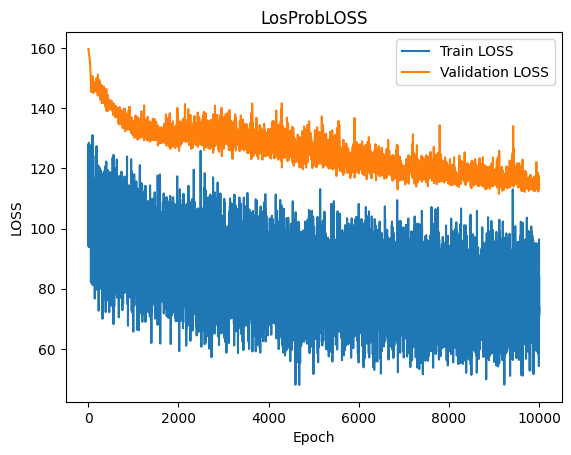

In [30]:
#plotting the Logprobloss after training
logprobloss = st.plot_loss(history_loss_train_file, history_loss_val_file, epoch_counter_train_loss_file)

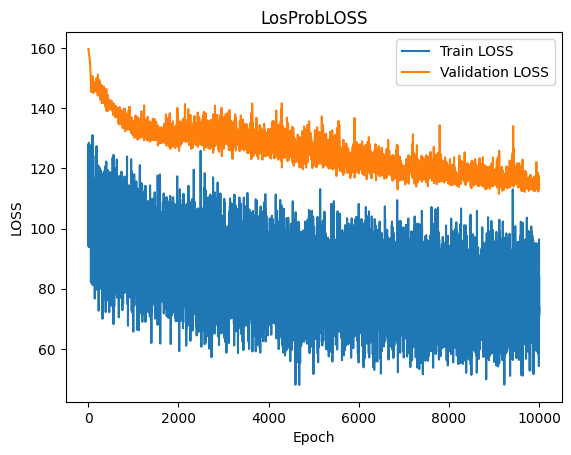

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x='epoch_counter_train_loss', y='history_loss_train', data=training_df, label='Train LOSS')
sns.lineplot(x='epoch_counter_train_loss', y='history_loss_val', data=training_df, label='Validation LOSS')
plt.title("LogProbLOSS")
plt.xlabel("Epoch")
plt.ylabel("LOSS")
plt.legend()
plt.show()


In [32]:
 # Replace with the path to your history_mse_train CSV file
history_mse_train_file = './history_mse_train.csv'
# Replace with the path to your history_mse_val CSV file
history_mse_val_file = './history_mse_val.csv'  
# Replace with the path to your epoch_counter_train_mse CSV file
epoch_counter_train_mse_file = './epoch_counter_train_mse.csv'  

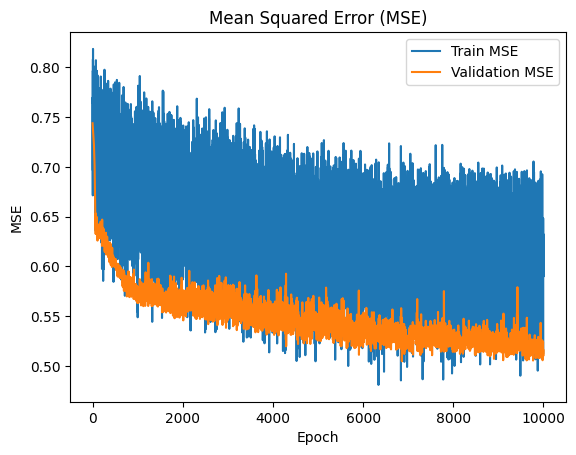

In [33]:
#plotting the MSE metric after training
msemetric=st.plot_mse(history_mse_train_file, history_mse_val_file, epoch_counter_train_mse_file)

In [34]:
# Replace with the path to your history_mae_train CSV file
history_mae_train_file = './history_mae_train.csv'
# Replace with the path to your history_mae_val CSV file
history_mae_val_file = './history_mae_val.csv'  
# Replace with the path to your epoch_counter_train_mae CSV file
epoch_counter_train_mae_file = './epoch_counter_train_mae.csv'  

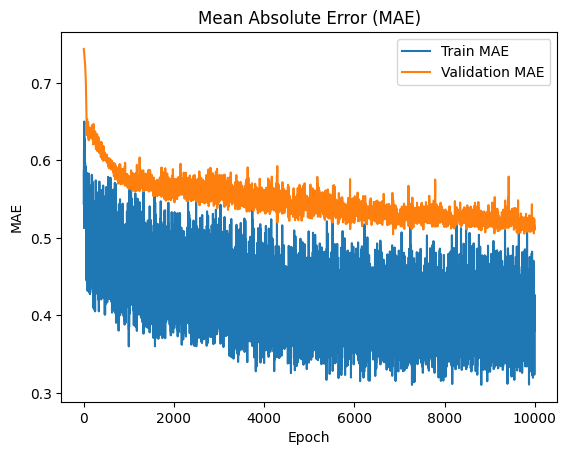

In [35]:
#plotting the MAE metric after training
maemetric=st.plot_mae(history_mae_train_file, history_mae_val_file, epoch_counter_train_mae_file)

In [36]:
# Saving the trained model

save = st.save_model(model, MODEL_PATH)

## Prediction

In [37]:
# This function call is optional, it is meant to be executed when output and it's child directiores are not empty.

pred.prepare_output_dir(OUTPUT_PATH)

In [38]:
# Loading the model load_trained_model function

model = pred.load_trained_model(MODEL_PATH, DEVICE)

In [39]:
# Getting the metric and criterion

criterion, mse_metric = pred.get_criteria()

In [40]:
# Calling all three functions and the same time

if __name__ == "__main__":

    pred.remove_padded_values_and_filter(VAL_DIR_PATH)
    pred.remove_padded_values_and_filter(TEST_DIR_PATH)
    pred.remove_padded_values_and_filter(TRAIN_DIR_PATH)

Deleted file with 'minus' or 'plus' in the name: 1400894_minus_split17.csv
Deleted file with 'minus' or 'plus' in the name: 1384482_minus_split19.csv
Removed padding in file: 1409195_original_split28.csv
Removed padding in file: 1461135_original_split29.csv
Deleted file with 'minus' or 'plus' in the name: 1385498_plus_split10.csv
Deleted file with 'minus' or 'plus' in the name: 1396861_minus_split16.csv
Removed padding in file: 1385148_original_split18.csv
Deleted file with 'minus' or 'plus' in the name: 1399759_plus_split33.csv
Deleted file with 'minus' or 'plus' in the name: 1397099_minus_split31.csv
Removed padding in file: 1400894_original_split22.csv
Removed padding in file: 1396377_original_split0.csv
Deleted file with 'minus' or 'plus' in the name: 1400894_plus_split42.csv
Deleted file with 'minus' or 'plus' in the name: 1392335_plus_split38.csv
Deleted file with 'minus' or 'plus' in the name: 1396377_plus_split45.csv
Deleted file with 'minus' or 'plus' in the name: 1397099_plus

Defining train test and validation loaders.

In [41]:
# Defining test loader

test_loader = pred.load_test_data(TEST_DIR_PATH)

In [42]:
# Defining train loader

train_loader = pred.load_train_data(TRAIN_DIR_PATH)

In [43]:
# Defining validation loader

val_loader = pred.load_val_data(VAL_DIR_PATH)

In [44]:
# Prediction and plotting the test metrics

test_metrics = pred.plot_light_curves_from_test_set(model, test_loader, criterion, mse_metric, plot_function, DEVICE)

# Saving the test metrics

save_test_metric = pred.save_test_metrics('./output/predictions/', test_metrics)

100%|██████████| 3/3 [00:00<00:00,  4.48it/s]


<Figure size 640x480 with 0 Axes>

In [45]:
# Prediction and plotting the train data

train_metrics=pred.plot_light_curves_from_train_set(train_loader, model, criterion, mse_metric, plot_function, DEVICE)

# Saving the train metrics

save_train_metric=pred.save_train_metrics('./output/predictions/', train_metrics)

100%|██████████| 11/11 [00:01<00:00,  7.49it/s]


<Figure size 640x480 with 0 Axes>

In [46]:
# Prediction and plotting the validation metrics

val_metrics=pred.plot_light_curves_from_val_set(model, val_loader, criterion, mse_metric, plot_function, DEVICE)

# Saving the validation metrics

save_val_metrics=pred.save_val_metrics('./output/predictions/', val_metrics)

100%|██████████| 2/2 [00:00<00:00,  6.74it/s]


<Figure size 640x480 with 0 Axes>